# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [60]:
pip install finance-datareader

In [61]:
import FinanceDataReader as fdr

In [62]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [63]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-11-03,106900,111500,106500,111100,30110066,0.033488
2025-11-04,111800,112400,104900,104900,30450281,-0.055806
2025-11-05,101000,102000,96700,100600,44843020,-0.040991
2025-11-06,103700,103800,98800,99200,28655689,-0.013917
2025-11-07,96400,100300,96300,97900,22877249,-0.013105


**미국 주식 데이터**도 가져올 수 있습니다.

In [64]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [65]:
apple.tail()

,Open,High,Low,Close,Volume,Adj Close
2025-11-03,270.420013,270.850006,266.250000,269.049988,50194600,269.049988
2025-11-04,268.329987,271.489990,267.619995,270.040009,49274800,270.040009
2025-11-05,268.609985,271.700012,266.929993,270.140015,43683100,270.140015
2025-11-06,267.890015,273.399994,267.890015,269.769989,51204000,269.769989
2025-11-07,269.799988,272.290009,266.769989,268.470001,48203600,268.470001


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [69]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [70]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
2017-01-03,28.950001,29.082500,28.690001,29.037500,115127600,26.796835
2017-01-04,28.962500,29.127501,28.937500,29.004999,84472400,26.766846
2017-01-05,28.980000,29.215000,28.952499,29.152500,88774400,26.902960
2017-01-06,29.195000,29.540001,29.117500,29.477501,127007600,27.202887
2017-01-09,29.487499,29.857500,29.485001,29.747499,134247600,27.452045


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [71]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '2023-01-01', '2025-11-07')

In [72]:
ford.head()

,Open,High,Low,Close,Volume,Adj Close
2023-01-03,11.82,11.92,11.57,11.68,45809000,9.197226
2023-01-04,11.88,12.08,11.74,12.01,53429700,9.457076
2023-01-05,12.11,12.38,11.88,12.25,50785600,9.646060
2023-01-06,12.12,12.59,12.10,12.58,53089100,9.905912
2023-01-09,12.74,12.93,12.55,12.69,50865500,9.992530


In [73]:
ford.tail()

,Open,High,Low,Close,Volume,Adj Close
2025-10-31,13.04,13.17,12.99,13.13,68862000,12.979885
2025-11-03,13.10,13.10,12.90,13.01,80419400,12.861258
2025-11-04,12.91,12.93,12.75,12.79,70360600,12.643772
2025-11-05,12.92,13.31,12.88,13.11,79134300,12.960114
2025-11-06,13.14,13.26,12.98,13.12,82291000,12.969999


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [ ]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [74]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [75]:
stock = fdr.DataReader(STOCK_CODE)

In [76]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-08-16,25720,26020,25640,25900,228332,NaN
2013-08-19,25720,25920,25600,25720,129997,-0.006950
2013-08-20,25920,26100,25380,25380,284619,-0.013219
2013-08-21,25300,25640,25120,25120,246921,-0.010244
2013-08-22,25000,25340,24900,25100,239697,-0.000796


In [77]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-11-03,106900,111500,106500,111100,30110066,0.033488
2025-11-04,111800,112400,104900,104900,30450281,-0.055806
2025-11-05,101000,102000,96700,100600,44843020,-0.040991
2025-11-06,103700,103800,98800,99200,28655689,-0.013917
2025-11-07,96400,100300,96300,97900,22877249,-0.013105


In [78]:
stock.index

DatetimeIndex(['2013-08-16', '2013-08-19', '2013-08-20', '2013-08-21',
               '2013-08-22', '2013-08-23', '2013-08-26', '2013-08-27',
               '2013-08-28', '2013-08-29',
               ...
               '2025-10-27', '2025-10-28', '2025-10-29', '2025-10-30',
               '2025-10-31', '2025-11-03', '2025-11-04', '2025-11-05',
               '2025-11-06', '2025-11-07'],
              dtype='datetime64[ns]', name='Date', length=3000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [79]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [23]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2013-08-16,25720,26020,25640,25900,228332,NaN,2013,8,16
2013-08-19,25720,25920,25600,25720,129997,-0.006950,2013,8,19
2013-08-20,25920,26100,25380,25380,284619,-0.013219,2013,8,20
2013-08-21,25300,25640,25120,25120,246921,-0.010244,2013,8,21
2013-08-22,25000,25340,24900,25100,239697,-0.000796,2013,8,22


## 시각화

Text(0, 0.5, 'price')

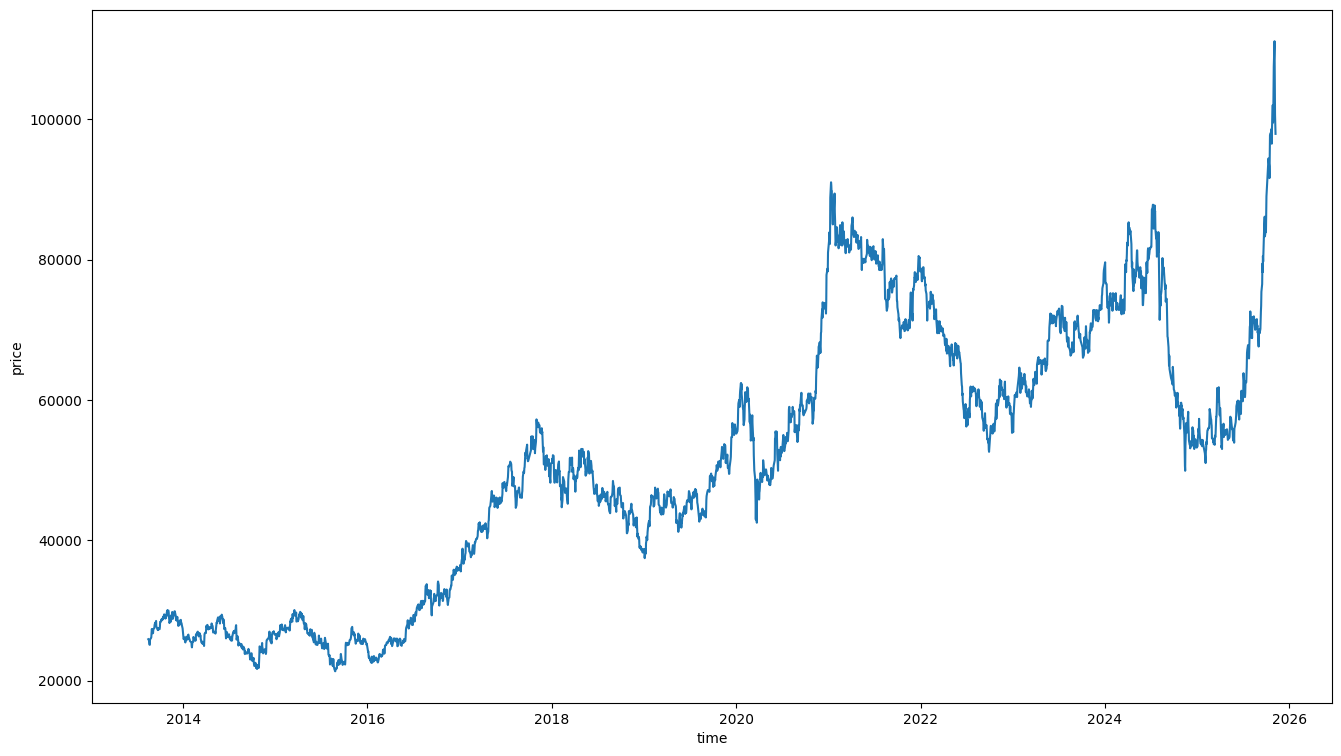

In [80]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

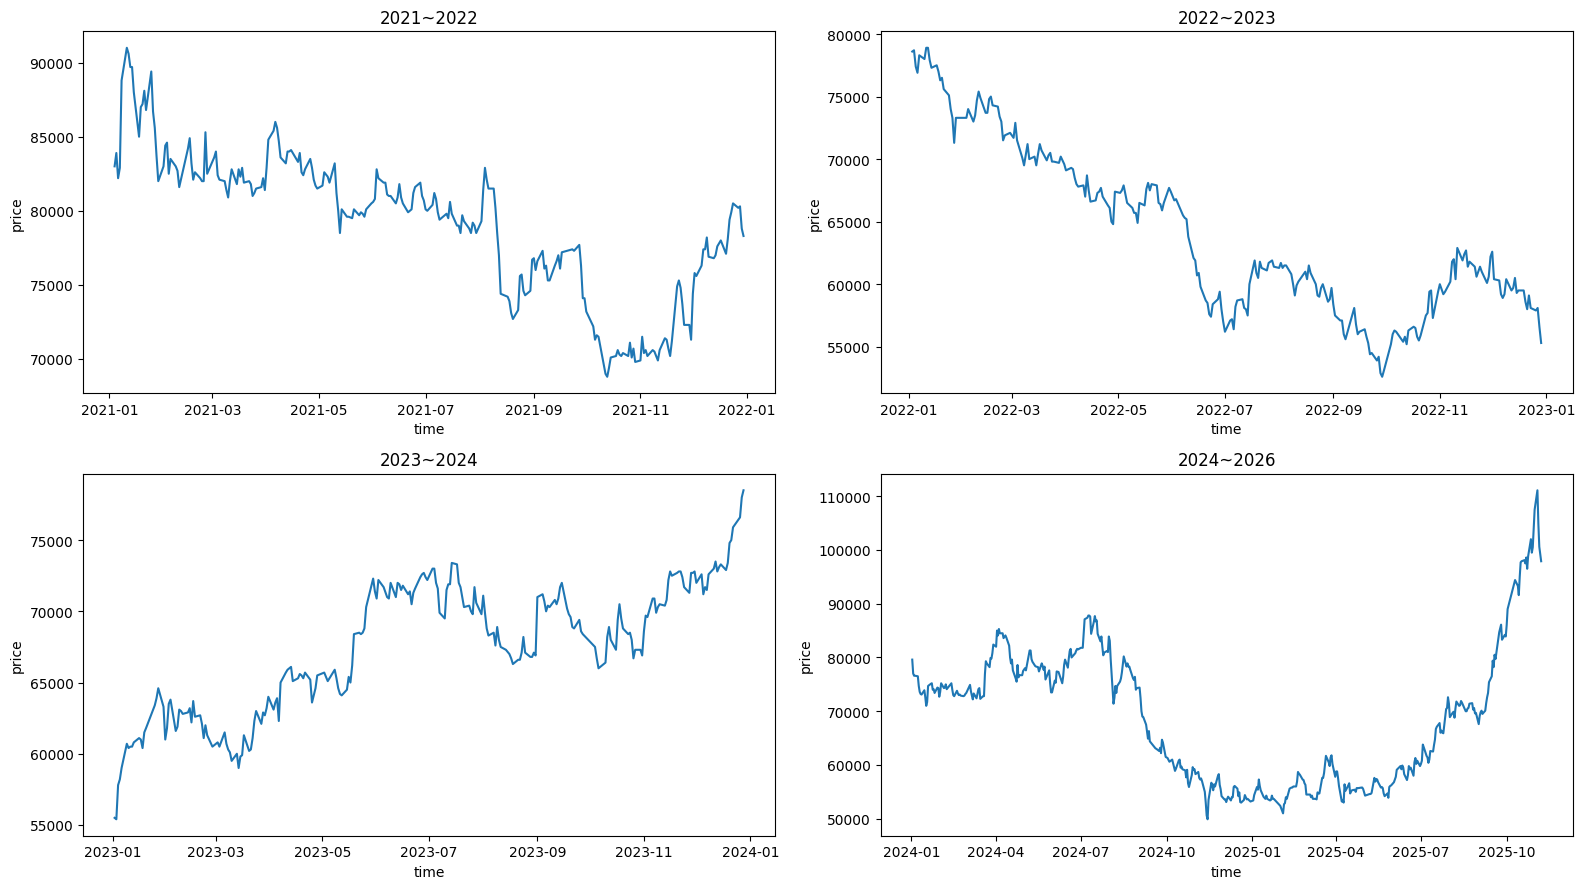

In [82]:
time_steps = [['2021', '2022'],
              ['2022', '2023'],
              ['2023', '2024'],
              ['2024', '2026']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [83]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.23005367, 0.23149466, 0.24075117, 0.05080214, 0.00252842],
       [0.23005367, 0.23060498, 0.24037559, 0.04879679, 0.00143951],
       [0.23184258, 0.23220641, 0.23830986, 0.04500891, 0.00315171],
       ...,
       [0.90339893, 0.90747331, 0.90798122, 0.88302139, 0.49656648],
       [0.92754919, 0.92348754, 0.92769953, 0.86742424, 0.31731704],
       [0.86225403, 0.89234875, 0.90422535, 0.85294118, 0.25332984]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [84]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [87]:
x_train.shape, y_train.shape

((2400, 4), (2400,))

In [88]:
x_test.shape, y_test.shape

((600, 4), (600,))

In [89]:
x_train

,Open,High,Low,Volume
0,0.230054,0.231495,0.240751,0.002528
1,0.230054,0.230605,0.240376,0.001440
2,0.231843,0.232206,0.238310,0.003152
3,0.226297,0.228114,0.235869,0.002734
4,0.223614,0.225445,0.233803,0.002654
...,...,...,...,...
2395,0.573345,0.574733,0.600000,0.090492
2396,0.588551,0.586299,0.613146,0.136587
2397,0.589445,0.586299,0.608451,0.118990
2398,0.590340,0.588968,0.616901,0.159809


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [90]:
import tensorflow as tf

In [91]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [97]:
WINDOW_SIZE=25
BATCH_SIZE=32

In [98]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [99]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 25, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [101]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [102]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [103]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     75/Unknown 2s 7ms/step - loss: 0.0157 - mse: 0.0315
Epoch 1: val_loss improved from inf to 0.00312, saving model to tmp/ckeckpointer.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0157 - mse: 0.0314 - val_loss: 0.0031 - val_mse: 0.0062
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mse: 0.0029
Epoch 2: val_loss improved from 0.00312 to 0.00088, saving model to tmp/ckeckpointer.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mse: 0.0029 - val_loss: 8.8006e-04 - val_mse: 0.0018
Epoch 3/50
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7998e-04 - mse: 3.5996e-04
Epoch 3: val_loss improved from 0.00088 to 0.00084, saving model to tmp/ckeckpointer.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8582e-04 - mse: 3.7164e-04 - val_loss: 8.3809e-04 - val_mse: 0.0017
Epoch 4/50
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5013e-04 - mse: 3.0026e-04
Epoch 4: val_loss improved from 0.00084 to 0.00078, saving mode

저장한 ModelCheckpoint 를 로드합니다.

In [104]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [105]:
pred = model.predict(test_data)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [106]:
pred.shape

(575, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

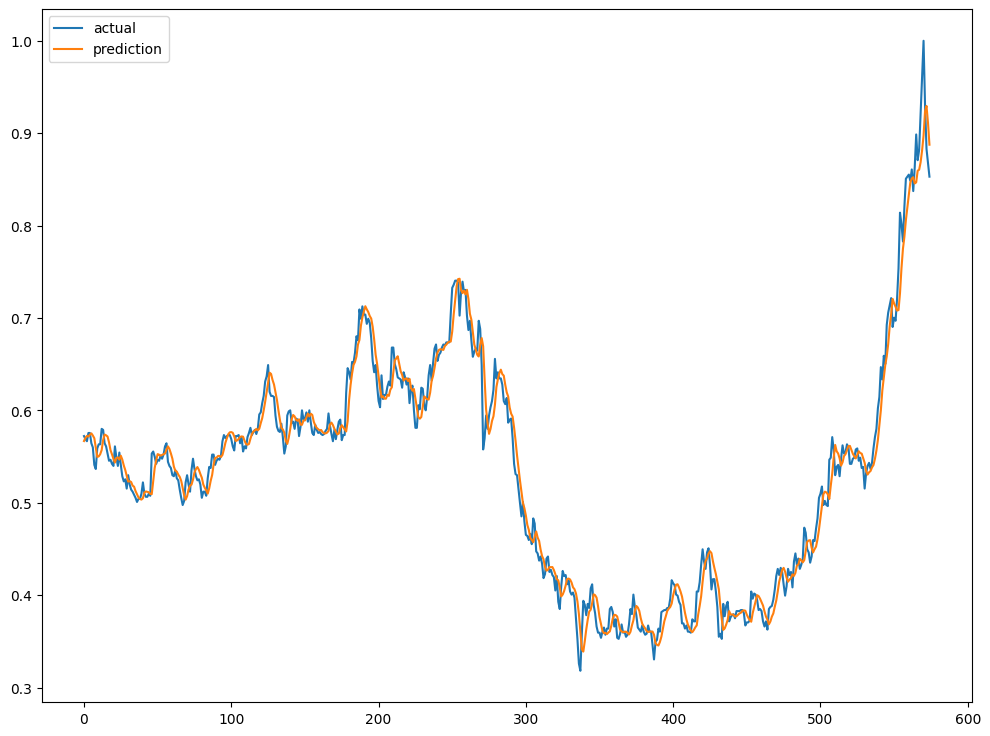

In [108]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[25:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

### 예측 결과 원래 스케일로 되돌리기 및 시각화

모델의 예측값 `pred`와 실제값 `y_test`는 `MinMaxScaler`를 통해 정규화된 상태입니다. 이 값들을 원래의 주가 범위로 되돌리려면 `scaler.inverse_transform()` 메서드를 사용해야 합니다.

주의할 점은 `scaler`가 `Open`, `High`, `Low`, `Close`, `Volume` 다섯 개의 컬럼으로 학습되었기 때문에 `inverse_transform`을 호출할 때도 동일한 5개 컬럼의 형태를 맞춰주어야 합니다. 이를 위해 `x_test` (정규화된 Open, High, Low, Volume)와 `pred` 또는 `y_test` (정규화된 Close)를 결합하여 임시 데이터프레임을 생성한 후 `inverse_transform`을 적용합니다.

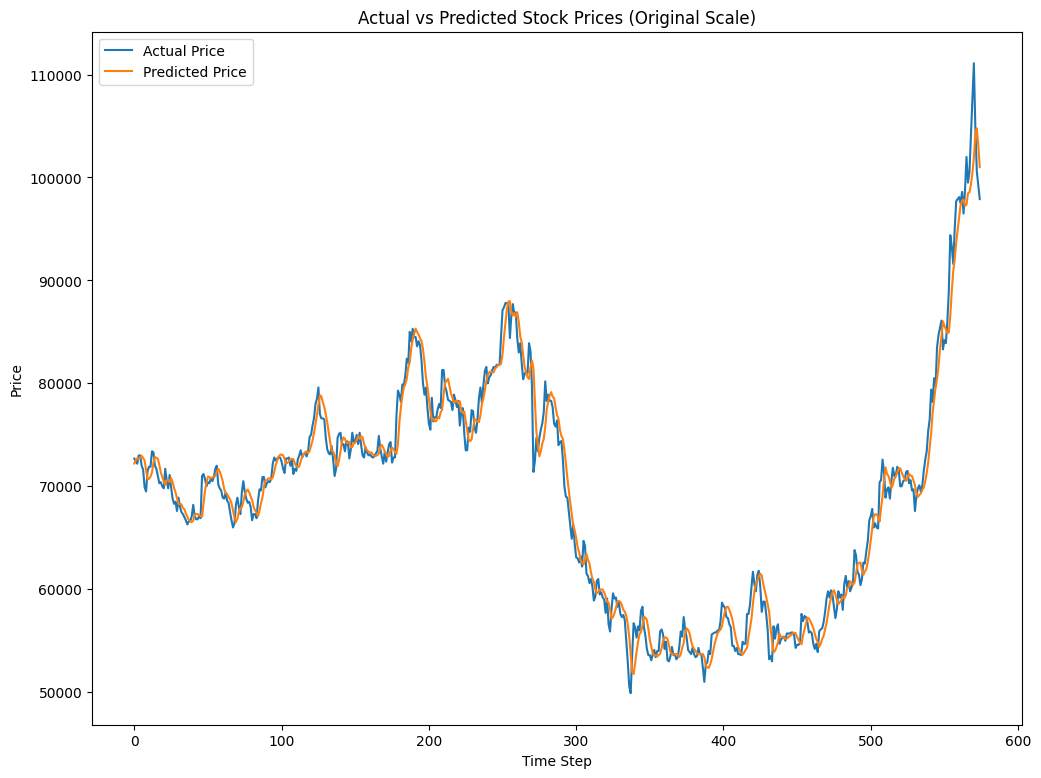

In [109]:
# 예측된 'Close' 가격을 원래 스케일로 되돌리기
# inverse_transform을 위해 원본 스케일링에 사용된 모든 컬럼(Open, High, Low, Close, Volume)이 필요합니다.
# x_test에는 Open, High, Low, Volume이 정규화된 상태로 포함되어 있습니다.
# 여기에 예측된 pred 값을 'Close' 컬럼으로 추가하여 inverse_transform을 수행합니다.

# pred는 (n_samples, 1) 형태이므로 flatten하여 Series 형태로 만듭니다.
pred_flatten = pred.flatten()

# y_test의 길이와 pred의 길이가 다르므로 (WINDOW_SIZE=20 때문에) x_test와 y_test를 pred의 길이에 맞춰 자릅니다.
# test_data는 y_test[WINDOW_SIZE:] 에 해당하므로 x_test도 그에 맞게 자릅니다.
# 실제 pred의 길이는 len(y_test) - WINDOW_SIZE 와 같습니다.
actual_pred_len = len(y_test) - WINDOW_SIZE
x_test_for_inverse = x_test.iloc[WINDOW_SIZE:].copy()
y_test_for_inverse = y_test.iloc[WINDOW_SIZE:].copy()

# 예측값을 포함한 임시 데이터프레임 생성
# 컬럼 순서는 scale_cols와 동일하게 맞춰야 합니다.
scaled_pred_df = x_test_for_inverse.copy()
scaled_pred_df['Close'] = pred_flatten
scaled_pred_df = scaled_pred_df[scale_cols] # Ensure column order matches original scaling

# 실제값을 포함한 임시 데이터프레임 생성
scaled_actual_df = x_test_for_inverse.copy()
scaled_actual_df['Close'] = y_test_for_inverse.values # Convert Series to numpy array
scaled_actual_df = scaled_actual_df[scale_cols] # Ensure column order matches original scaling

# inverse_transform 적용
original_pred_data = scaler.inverse_transform(scaled_pred_df)
original_actual_data = scaler.inverse_transform(scaled_actual_df)

# 원래 스케일의 예측 'Close' 가격과 실제 'Close' 가격 추출
original_pred_close = original_pred_data[:, scale_cols.index('Close')]
original_actual_close = original_actual_data[:, scale_cols.index('Close')]

# 시각화
plt.figure(figsize=(12, 9))
plt.plot(original_actual_close, label='Actual Price')
plt.plot(original_pred_close, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


In [112]:
print(f"삼성전자 예측 : {original_pred_close[570]}")
print(f"삼전자자 종가 : {original_actual_close[570]}")

삼성전자 예측 : 101891.7173576355
삼전자자 종가 : 111100.0


In [ ]:
0